# Exploratory analysis of fMRI psychois spectrum data
* **Objectives:** 
    1. Classify functional networks / correlation matrices into Dx categories
    
        
* **Methods:** 
    1. 2D convnets using TensorFlow
    
        
* **Validation:** 
    1. 10-fold CV (no nested innerloop yet for hyper-parameter tuning)
    

In [1]:
# Package imports
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import math
from sklearn.cross_validation import StratifiedKFold
#import h5py as h5
#import SimpleITK as sitk
from sklearn.preprocessing import StandardScaler

#Data: http://repo.mouseimaging.ca/repo/for_Nikhil/

/projects/nikhil/ADNI_prediction/code/conda_envs/tensorflow_gpu/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [14]:
# Model Architecture Defs
#MLP
def build_model(X_,_dropout,node_sizes,net_type):
    if net_type == 'mlpnet':
        model = mlpnet(X_,_dropout,node_sizes)
    elif net_type == 'convnet':
        model = convnet(X_,_dropout,node_sizes)
    else: 
        print('unknown net architecture type')
    return model

def mlpnet(image,_dropout,node_sizes):
    l1 = mlp(image,node_sizes['input'],node_sizes['l1'],name='l1')
    l1 = tf.nn.dropout(l1,_dropout)
    l2 = mlp(l1,node_sizes['l1'],node_sizes['l2'],name='l2')
    l2 = tf.nn.dropout(l2,1)
#     l3 = mlp(l2,node_sizes['l2'],node_sizes['l3'],name='l3')
#     l3 = tf.nn.dropout(l3,1)
    l4 = mlp(l2,node_sizes['l2'],node_sizes['output'],name='l4')
    return l4

def mlp(input_,input_dim,output_dim,name="mlp"):
    with tf.variable_scope(name):
        #w = tf.get_variable('w',[input_dim,output_dim],tf.float32,tf.random_normal_initializer(mean = 0.001,stddev=0.02))
        w = tf.get_variable('w',[input_dim,output_dim],tf.float32,tf.contrib.layers.xavier_initializer())
        #return tf.nn.tanh(tf.matmul(input_,w))
        return tf.nn.relu(tf.matmul(input_,w))
    
#Convnet
def convnet(X_,_dropout,node_sizes):
    #image_dim = int(np.sqrt(node_sizes['input']))
    image_dim = node_sizes['input']
    final_image_vector_size = int(node_sizes['input'][0]*node_sizes['input'][1]/node_sizes['max_pool_redux_factor'])
    
    X_image = tf.reshape(X_, [-1,image_dim[0],image_dim[1],1])
    l1 = conv(X_image,node_sizes['kernel_dim'], 1, node_sizes['l1'], name='l1')  
    l1 = tf.nn.dropout(l1,_dropout)
    l2 = conv(l1,node_sizes['kernel_dim'], node_sizes['l1'], node_sizes['l2'], name='l2')
    l2 = tf.nn.dropout(l2,_dropout)
#     l3 = conv(l2,node_sizes['kernel_dim'], node_sizes['l2'], node_sizes['l3'], name='l3')
#     l3 = tf.nn.dropout(l3,_dropout)
    
    #reshape to vector (reduced image size*number of filters)
    l3_flat = tf.reshape(l2, [-1, final_image_vector_size*node_sizes['l2']])    
    l4 = mlp(l3_flat,final_image_vector_size*node_sizes['l2'],node_sizes['output'],name='mlp_1')    
#     l4 = tf.nn.dropout(l4,_dropout) #Doesnt work well

    output = tf.nn.softmax(l4)
    return output
    
def conv(input_, kernel_dim, in_channels, output_dim,name="conv"):
    with tf.variable_scope(name):
        W = tf.get_variable('w',[kernel_dim, kernel_dim, in_channels, output_dim],
                            tf.float32,tf.random_normal_initializer(mean = 0.01,stddev=0.02))
        b = tf.get_variable('b',[output_dim],tf.float32,tf.constant_initializer(0.1))                        
        h_conv = tf.nn.relu(conv2d(input_, W) + b)
        h_pool = max_pool_2x2(h_conv)
        return h_pool
    
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    
def next_batch(s,e,inputs,labels):
    input1 = inputs[s:e]
    y = np.reshape(labels[s:e],(len(range(s,e)),2))
    return input1,y

def compute_accuracy(prediction,labels):
    correct_prediction = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
    acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))    
    return acc

def pickleIt(my_data,save_path):
    f = open(save_path, 'wb')
    pickle.dump(my_data, f ,protocol=2)
    f.close()

In [3]:
#Data imports (Separate loops for images with segmentations and images without segmentations)

#baseline_dir = '/projects/doverton/for_nikhil/'
baseline_dir = '/scratch/nbhagwat/fMRI_psychosis_Dawson/'

input_data_path = baseline_dir + 'X_array_bold_square'

with open(input_data_path, 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    input_data = np.array(u.load())

input_labels_path = baseline_dir + 'y_array_bold_square'
input_labels = np.array(pickle.load(open(input_labels_path, "rb")))

In [4]:
print('X_shape: {}, y_shape: {}'.format(input_data.shape, input_labels.shape))
sampx = input_data.shape[0]
featx = input_data.shape[1]
print('label distribution: {},{}'.format(np.sum(input_labels==0),np.sum(input_labels==1)))

X_shape: (1202, 252, 252), y_shape: (1202,)
label distribution: 895,307


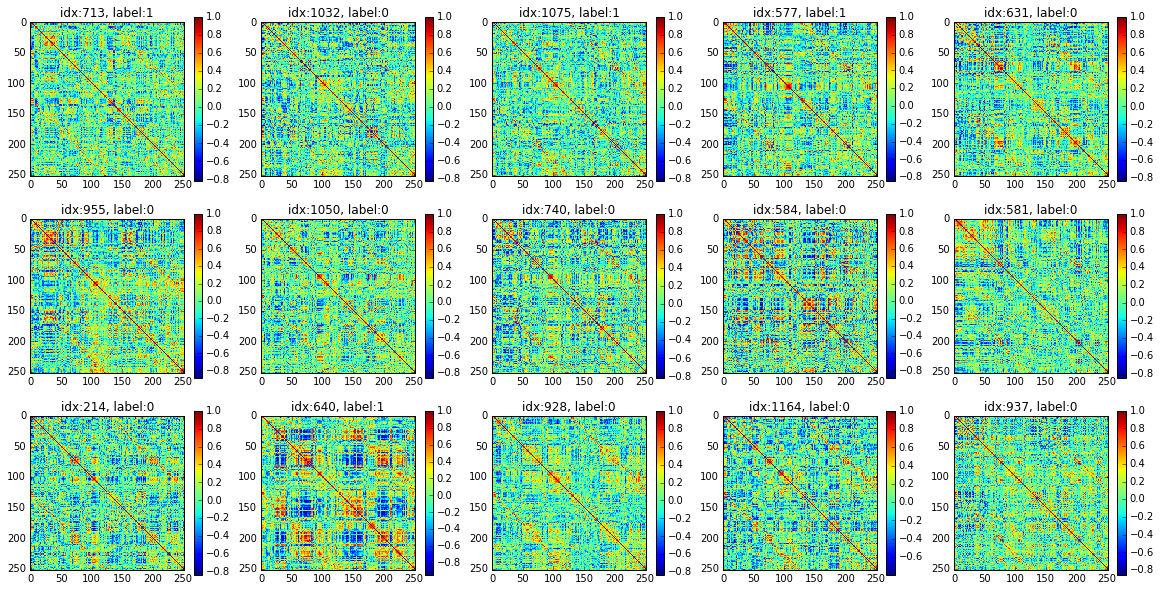

In [5]:
# plot sample image and label slices to visualize tumors in 2D slice
plt.figure(figsize=(20,10))
example_images = 15
mask_offset = 10000
for p, idx in enumerate(np.random.randint(0,sampx,example_images)):
    plt.subplot(example_images/5,5,p+1)
    plt.imshow(input_data[idx,:,:],interpolation='nearest')
    plt.colorbar()
    plt.title('idx:{}, label:{}'.format(idx,input_labels[idx]))


In [6]:
# Currently simply doing 10 sKF
n = sampx
d = featx

foldx = 10
exp_name = 'fmri_psychosis_test1'
save_experimental_setup = False

X_train_list = []
X_valid_list = []
X_test_list = []

y_train_list = []
y_valid_list = []
y_test_list = []

X = input_data
y_raw = input_labels

#One-hot
y = np.vstack((y_raw==True,y_raw==False)).T.astype(int)
print(X.shape, y.shape)

sKF = StratifiedKFold(y_raw, n_folds=10)

for train_index, test_index in sKF:    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print('y distribution: train:{},{}, test:{},{}'.format(np.sum(y_train[:,0]==1),np.sum(y_train[:,1]==1),
                                                           np.sum(y_test[:,0]==1),np.sum(y_test[:,1]==1)))
    
    val_split = int(0.9*len(y_train)) #For hyperparam tuning
    X_train_list.append(X_train[:val_split])
    X_valid_list.append(X_train[val_split:])
    X_test_list.append(X_test)
    y_train_list.append(y_train[:val_split])
    y_valid_list.append(y_train[val_split:])
    y_test_list.append(y_test)

save_path = baseline_dir  + exp_name + '_sKF.pkl'    
print('Saving exp_setup to: {}'.format(save_path))
if save_experimental_setup:    
    exp_setup = {'exp_name':exp_name,'X':X,'y':y,'sKF':sKF}
    pickleIt(exp_setup, save_path)    

    

(1202, 252, 252) (1202, 2)
y distribution: train:276,805, test:31,90
y distribution: train:276,805, test:31,90
y distribution: train:276,805, test:31,90
y distribution: train:276,805, test:31,90
y distribution: train:276,805, test:31,90
y distribution: train:276,806, test:31,89
y distribution: train:276,806, test:31,89
y distribution: train:277,806, test:30,89
y distribution: train:277,806, test:30,89
y distribution: train:277,806, test:30,89
Saving exp_setup to: /scratch/nbhagwat/fMRI_psychosis_Dawson/fmri_psychosis_test1_sKF.pkl


In [7]:
val_split

974

# TensorFlow configs
    1. Running K-fold in a for loop (not parallel)
    2. Prints out average test acc at the end
    3. Using fixed TF architecture (no hyperparameter tuning)

In [16]:
## Run TF

# Basic configs
batch_size = 100
num_epochs = 5
foldx = 1
lr = 0.005
keep_p = 0.5

train_loss = []
train_acc = []
valid_acc = []
test_acc = []

test_fold_acc = []

#Tensorboard
logs_path = "{}TF_logs/1".format(baseline_dir)

for fid in range(foldx):  
    print(fid)
    X_train = X_train_list[fid]
    X_valid = X_valid_list[fid]
    X_test = X_test_list[fid]
    y_train = y_train_list[fid]
    y_valid = y_valid_list[fid]
    y_test = y_test_list[fid]
    node_sizes = {'input':[252,252],'l1':50,'l2':50,'l3':50,'output':2,'kernel_dim':10,'max_pool_redux_factor':16}
    with tf.Graph().as_default():    
        data = tf.placeholder(tf.float32,shape=([None,node_sizes['input'][0], node_sizes['input'][1]]),name='input_data')        
        labels = tf.placeholder(tf.float32,shape=([None,2]),name='gt')                
        dropout_f = tf.placeholder("float")

        with tf.variable_scope("psych_fmri_net") as scope:
            model1= build_model(data,dropout_f,node_sizes,'convnet')            
            
        
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model1,labels=labels))         
        acc = compute_accuracy(model1,labels)
        
#         t_vars = tf.trainable_variables()
#         d_vars  = [var for var in t_vars if 'l' in var.name]
#         batch = tf.Variable(0)
        optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(loss)
        #optimizer = tf.train.RMSPropOptimizer(0.0001,momentum=0.9,epsilon=1e-6).minimize(loss)

        #Tensorboard
        # create a summary for our cost and accuracy
        tf.summary.scalar("loss", loss)
        tf.summary.histogram("accuracy", acc)  
        
        #Tensorboard
        summary_op = tf.summary.merge_all()
        # create log writer object
        train_writer = tf.summary.FileWriter(logs_path + '/train', graph=tf.get_default_graph())
        test_writer = tf.summary.FileWriter(logs_path + '/test', graph=tf.get_default_graph())
        
        # Launch the graph
        with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
            #sess.run(init)
            tf.initialize_all_variables().run()
            # Training cycle
            for epoch in range(num_epochs):
                avg_loss = 0.
                avg_acc = 0.
                total_batch = int(X_train.shape[0]/batch_size)
                start_time = time.time()
                # Loop over all batches
                for i in range(total_batch):
                    s  = i * batch_size
                    e = (i+1) *batch_size
                    
                    # Fit training using batch data
                    tr_X,tr_y = next_batch(s,e,X_train,y_train)  
                    #print(input1.shape, y.shape)
                                
                    _,tr_loss,tr_acc,summary=sess.run([optimizer,loss,acc,summary_op], 
                                                  feed_dict={data:tr_X,labels:tr_y,dropout_f:keep_p})
                    
                    predict=model1.eval(feed_dict={data:tr_X,dropout_f:1.0})                    
                    tr_acc = compute_accuracy(predict,tr_y).eval()                
                                        
                    avg_loss += tr_loss
                    avg_acc +=tr_acc*100
        
                    #Tensorboard
                    train_writer.add_summary(summary, epoch * total_batch + i)
                                        
                
                duration = time.time() - start_time
                #print('epoch %d  time: %f loss %0.5f acc %0.2f' %(epoch,duration,avg_loss/(total_batch),avg_acc/total_batch))
                train_loss.append(avg_loss/(total_batch))
                train_acc.append(avg_acc/total_batch)
                
                #Check performance on validation set                                                                                
                predict=model1.eval(feed_dict={data:X_valid,dropout_f:1.0})                
                va_acc = compute_accuracy(predict,y_valid).eval()*100.0
                valid_acc.append(va_acc)
                
                print('elapsed time: {}'.format(duration))
                print('epoch {} loss {}'.format(epoch,avg_loss/total_batch))
                print('Accuracy train {}, validation {}'.format(tr_acc,va_acc))
                
                # Test model                                    
                predict= model1.eval(feed_dict={data:X_test,dropout_f:1.0})                
                te_acc = compute_accuracy(predict,y_test).eval()*100
                test_acc.append(te_acc)
                
                #Tensorboard
                test_writer.add_summary(summary, epoch*total_batch)
                
            #Accuracy of the entire training set at the end of training            
            predict= model1.eval(feed_dict={data:X_train, dropout_f:1.0})                
            tr_acc = compute_accuracy(predict,y_train).eval()*100
            print('Accuracy training set %0.2f' % (tr_acc))
            print('Accuracy validation set %0.2f' % (va_acc))


            # Test model                                    
            predict= model1.eval(feed_dict={data:X_test,dropout_f:1.0})                
            te_acc = compute_accuracy(predict,y_test)
            test_fold_acc.append(100 * te_acc.eval())
            print('Accuracy test set %0.4f' % (100 * te_acc.eval()))
        
print('')
print('test performance:{},{}'.format(np.mean(test_fold_acc),np.std(test_fold_acc)))
print('total train + test duration over all folds: {}'.format(time.time() - start_time))

0
Instructions for updating:
Use `tf.global_variables_initializer` instead.
elapsed time: 322.8981294631958
epoch 0 loss 0.6204321516884698
Accuracy train 0.6899999976158142, validation 70.64220309257507
elapsed time: 322.61841654777527
epoch 1 loss 0.5665950444009569
Accuracy train 0.6899999976158142, validation 70.64220309257507
elapsed time: 322.8461334705353
epoch 2 loss 0.5665950444009569
Accuracy train 0.6899999976158142, validation 70.64220309257507
elapsed time: 322.8394033908844
epoch 3 loss 0.5665950444009569
Accuracy train 0.6899999976158142, validation 70.64220309257507
elapsed time: 323.3891632556915
epoch 4 loss 0.5665950444009569
Accuracy train 0.6899999976158142, validation 70.64220309257507
Accuracy training set 74.90
Accuracy validation set 70.64
Accuracy test set 74.3802

test performance:74.38016533851624,0.0
total train + test duration over all folds: 429.10987067222595


In [13]:
predict

array([[-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       [-1.,

In [11]:
print('')
print(test_fold_acc)
print('test performance:{},{}'.format(np.mean(test_fold_acc),np.std(test_fold_acc)))


[74.380165338516235, 74.380165338516235, 74.380165338516235, 74.380165338516235, 74.380165338516235, 74.166667461395264, 74.166667461395264, 74.789917469024658, 74.789917469024658, 74.789917469024658]
test performance:74.46039140224457,0.23032388053032476


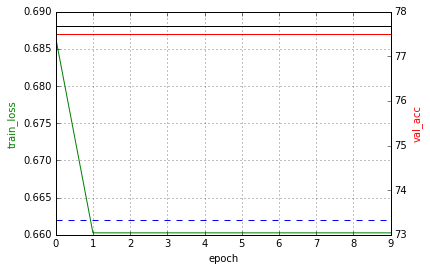

In [12]:
# Plot Acc and Loss
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(train_loss, 'g-')
ax2.plot(train_acc, 'b--')
ax2.plot(valid_acc, 'r-')
ax2.plot(test_acc, 'k-')


ax1.set_xlabel('epoch')
ax1.set_ylabel('train_loss', color='g')
ax2.set_ylabel('val_acc', color='r')
ax1.grid()

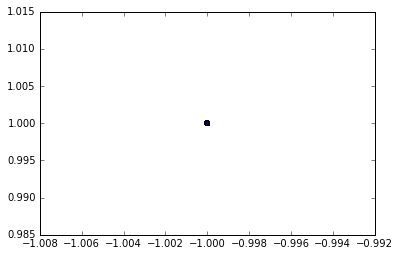

In [14]:
#Scatter plot of test predictions
plt.scatter(predict[:,0],predict[:,1],c=y_test[:,0],alpha=0.5,marker='o')

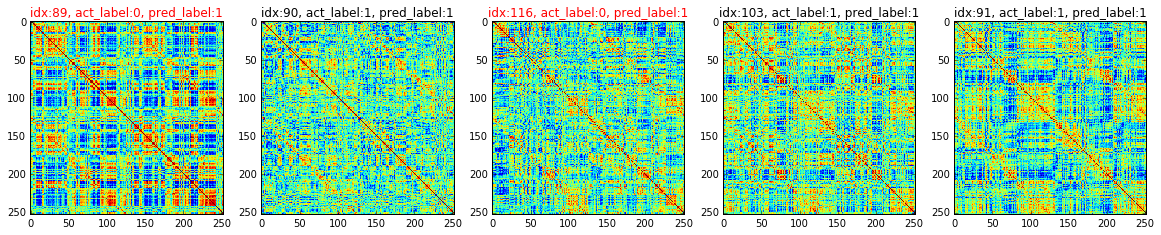

In [17]:
# Plot test images and predicted labels
# This will label wrong prediction titles in red

plt.figure(figsize=(20,50))
example_images = 5
for p, idx in enumerate(np.random.randint(0,X_test.shape[0],example_images)):
    plt.subplot(example_images/5,5,p+1)
    plt.imshow(X_test[idx,:,:],interpolation='nearest')
    #plt.colorbar()
    #print(y_test[idx,:],predict[idx,:])
    if np.argmax(y_test[idx,:])==np.argmax(predict[idx,:]):
        title_color = 'k'
    else:
        title_color = 'r'
        
    ax = plt.title('idx:{}, act_label:{}, pred_label:{}'.format(idx,np.argmax(y_test[idx,:]),np.argmax(predict[idx,:])))
    plt.setp(ax, color=title_color) 